In [136]:
import os
import librosa
import zipfile
from urllib.request import urlretrieve
from IPython.display import Audio

# Завантаження та розархівування датасету
url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
zip_file_path = "ESC-50-master.zip"
download_path = "./ESC-50-master/"
if not os.path.exists(download_path):
    urlretrieve(url, zip_file_path)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(download_path)
    os.remove(zip_file_path)

In [137]:
import pandas as pd
# Read CSV file ... meta/esc50.csv
df_file_path = os.path.join(download_path, "ESC-50-master/meta", "esc50.csv")
df = pd.read_csv(df_file_path)
df.head(5)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [138]:
# Select only 'dog' and 'chirping_birds'
data = df[df['category'].isin(['dog', 'chirping_birds'])]
print(data.category.value_counts())
data['category'] = data['category'].replace({'dog': 0, 'chirping_birds': 1}).astype('int32')

category
dog               40
chirping_birds    40
Name: count, dtype: int64


<ipython-input-138-f947aa133e99>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['category'] = data['category'].replace({'dog': 0, 'chirping_birds': 1}).astype('int32')


In [139]:
import numpy as np

def spectrogram(samples, sample_rate, stride_ms = 10.0,
                          window_ms = 20.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples,
                                          shape = nshape, strides = nstrides)

    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]

    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2

    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale

    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])

    # Compute spectrogram feature
    # ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:, :] + eps)
    return specgram

In [140]:
def pooling_audio(mat,ksize,method='max',pad=False):
    '''Non-overlapping pooling on 2D or 3D data.

    <mat>: ndarray, input array to pool.
    <ksize>: tuple of 2, kernel size in (ky, kx).
    <method>: str, 'max for max-pooling,
                   'mean' for mean-pooling.
    <pad>: bool, pad <mat> or not. If no pad, output has size
           n//f, n being <mat> size, f being kernel size.
           if pad, output has size ceil(n/f).

    Return <result>: pooled matrix.
    '''

    m, n = mat.shape[:2]
    ky,kx=ksize

    _ceil=lambda x,y: int(np.ceil(x/float(y)))

    if pad:
        ny=_ceil(m,ky)
        nx=_ceil(n,kx)
        size=(ny*ky, nx*kx)+mat.shape[2:]
        mat_pad=np.full(size,np.nan)
        mat_pad[:m,:n,...]=mat
    else:
        ny=m//ky
        nx=n//kx
        mat_pad=mat[:ny*ky, :nx*kx, ...]

    new_shape=(ny,ky,nx,kx)+mat.shape[2:]

    if method=='max':
        result=np.nanmax(mat_pad.reshape(new_shape),axis=(1,3))
    else:
        result=np.nanmean(mat_pad.reshape(new_shape),axis=(1,3))

    return result

In [141]:
vectors = []
window_size = (20, 20)
for filename in data['filename']:
    audio_file_path = os.path.join(download_path, "ESC-50-master/audio", filename)
    y, sr = librosa.load(audio_file_path, sr=None)
    # генерація матриці спектрограми
    spect_matrix = spectrogram(y, sr)
    # узагальнення та зменшення розміру спектрограми
    spect_matrix_pooling = pooling_audio(spect_matrix, window_size)
    # перетворення матриці у вектор
    vector = spect_matrix_pooling.flatten()
    vectors.append(vector)
vectors = np.array(vectors)

So, an array of vectors corresponding to audio files labeled 'dog' and 'chirping_birds' has been created. We will perform spectral clustering on the obtained vectors and check whether the vectors with different labels fall into different clusters. We will first apply standardization and then use Grid Search to find the best parameters for spectral clustering.

In [129]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
vectors_scaled = scaler.fit_transform(vectors)

In [142]:
# Find best parameters for spectral clustering
from sklearn.cluster import SpectralClustering
import warnings
from tqdm import tqdm
import itertools
from sklearn.metrics import f1_score, confusion_matrix

warnings.filterwarnings("ignore", category=UserWarning)
param_grid = {
    'assign_labels': ['kmeans', 'discretize', 'cluster_qr'],
    'n_neighbors': [5,7,10,15],
    'affinity': ['nearest_neighbors', 'rbf', ]
}

all_params = list(itertools.product(*param_grid.values()))

results_df = pd.DataFrame(columns=['assign_labels', 'n_neighbors', 'affinity', 'f1_score', 'accuracy'])

X_test = vectors_scaled
Y_test = data['category'].values

for params in tqdm(all_params, desc="Grid Search"):
    assign_labels, n_neighbors, affinity = params
    spectral = SpectralClustering(n_clusters=2,
                                  assign_labels=assign_labels,
                                  n_neighbors=n_neighbors,
                                  affinity = affinity,
                                  random_state=1)

    predicted = spectral.fit_predict(X_test)

    f1 = f1_score(Y_test, predicted, average='weighted')

    conf_matrix = confusion_matrix(Y_test, predicted)
    accuracy = np.trace(conf_matrix)/np.sum(conf_matrix)

    results_df = pd.concat([results_df, pd.DataFrame([{
        'assign_labels': assign_labels,
        'n_neighbors': n_neighbors,
        'affinity': affinity,
        'f1_score': f1,
        'accuracy': accuracy
    }])], ignore_index=True)


results_df = results_df.sort_values(by='f1_score', ascending=False)

print("Best parameters:")
results_df.head()


Grid Search: 100%|██████████| 24/24 [00:06<00:00,  3.89it/s]

Best parameters:


,assign_labels,n_neighbors,affinity,f1_score,accuracy
4,kmeans,10,nearest_neighbors,0.749373,0.750
12,discretize,10,nearest_neighbors,0.724828,0.725
6,kmeans,15,nearest_neighbors,0.724828,0.725
14,discretize,15,nearest_neighbors,0.724828,0.725
10,discretize,7,nearest_neighbors,0.724311,0.725


In [143]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=2, assign_labels = 'kmeans', n_neighbors =10, affinity='nearest_neighbors', random_state=1)

clusters = sc.fit_predict(vectors_scaled)
data['cluster'] = clusters
data

<ipython-input-143-62797555ce2a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = clusters


,filename,fold,target,category,esc10,src_file,take,cluster
0,1-100032-A-0.wav,1,0,0,True,100032,A,0
1,1-100038-A-14.wav,1,14,1,False,100038,A,1
14,1-110389-A-0.wav,1,0,0,True,110389,A,0
157,1-30226-A-0.wav,1,0,0,True,30226,A,0
158,1-30344-A-0.wav,1,0,0,True,30344,A,0
...,...,...,...,...,...,...,...,...
1919,5-243450-A-14.wav,5,14,1,False,243450,A,0
1920,5-243459-A-14.wav,5,14,1,False,243459,A,1
1921,5-243459-B-14.wav,5,14,1,False,243459,B,1
1972,5-257839-A-14.wav,5,14,1,False,257839,A,1


In [144]:
from sklearn.metrics import confusion_matrix

# Матриця помилок
conf_mat = confusion_matrix(data['category'], data['cluster'])
print(conf_mat)

[[32  8]
 [12 28]]


Let's analyze the resulting confusion matrix: 32 out of 40 instances corresponding to audio files labeled 'dog' and 28 out of 40 instances labeled 'chirping_birds' were correctly clustered into different clusters. According to the Grid Search results, we achieved an F1 score of 0.75. This indicates that using the Fast Fourier Transform for signal analysis is indeed meaningful and allows us to extract significant features for analysis.

In [145]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

visualization_df = pd.DataFrame(vectors_2d, columns=['PC1', 'PC2'])
visualization_df['actual'] = data['category'].values
visualization_df['actual']= visualization_df['actual'].replace({0: 'dog', 1: 'chirping_birds'})
visualization_df['predicted'] = data['cluster'].values
visualization_df['predicted']= visualization_df['predicted'].replace({0: 'dog', 1: 'chirping_birds'})
visualization_df

,PC1,PC2,actual,predicted
0,202.241831,7.489859,dog,dog
1,-85.114345,0.813889,chirping_birds,chirping_birds
2,213.283205,25.134772,dog,dog
3,18.223769,-51.710385,dog,dog
4,21.806166,-27.411420,dog,dog
...,...,...,...,...
75,3.067150,18.401395,chirping_birds,dog
76,-32.957445,8.261496,chirping_birds,chirping_birds
77,-28.145382,4.567231,chirping_birds,chirping_birds
78,-84.392401,1.971613,chirping_birds,chirping_birds


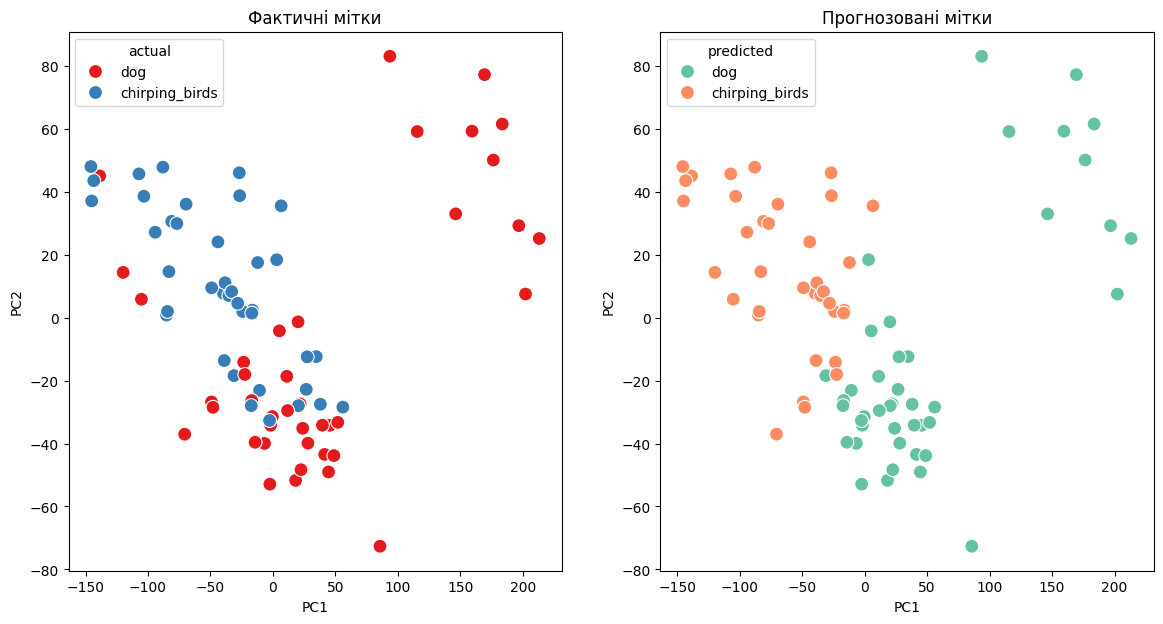

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.scatterplot(data=visualization_df, x='PC1', y='PC2', hue='actual', palette='Set1', s=100)
plt.title('Actual labels')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 2, 2)
sns.scatterplot(data=visualization_df, x='PC1', y='PC2', hue='predicted', palette='Set2', s=100)
plt.title('Predicted labels')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()


From the visualization, we can conclude that data clustering is complicated by the presence of overlaps in the clusters, which results in a not very high F1 score. We will check the accuracy of the classification of the vectors corresponding to the audio files using KNN.

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(vectors_scaled, data['category'], test_size=0.2, random_state=42)

metrics = ['euclidean', 'manhattan', 'cosine']

classification_results = {}

for metric in metrics:
    knn = KNeighborsClassifier(metric=metric)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    classification_results[metric] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

for metric, scores in classification_results.items():
    print(f"Metric: {metric}")
    for score_name, score_value in scores.items():
        print(f"  {score_name}: {score_value:.4f}")

Metric: euclidean
  accuracy: 0.8750
  precision: 0.9000
  recall: 0.8750
  f1_score: 0.8730
Metric: manhattan
  accuracy: 0.8750
  precision: 0.9000
  recall: 0.8750
  f1_score: 0.8730
Metric: cosine
  accuracy: 0.9375
  precision: 0.9444
  recall: 0.9375
  f1_score: 0.9373



We can see that the vectors obtained from the audio files using the Fast Fourier Transform can be used in classification models, particularly in the KNN model. When using cosine distances between vectors, the prediction accuracy reaches 93.8%, with an F1 score of 0.9375. Thus, the Fourier Transform is fundamentally important for feature extraction in data for further analysis and classification, especially when working with audio signals.